Environment changed at episode 20: new goal (2, 3), new obstacles [(2, 4), (0, 1), (1, 0), (2, 2)]
Environment changed at episode 40: new goal (0, 4), new obstacles [(1, 3), (0, 3), (4, 1), (2, 4)]
Environment changed at episode 60: new goal (1, 0), new obstacles [(1, 2), (4, 1), (0, 2), (0, 1)]
Environment changed at episode 80: new goal (4, 0), new obstacles [(2, 3), (3, 3), (4, 3), (3, 2)]
Environment changed at episode 20: new goal (2, 3), new obstacles [(2, 1), (3, 2), (1, 3), (4, 3)]
Environment changed at episode 40: new goal (3, 3), new obstacles [(3, 4), (3, 1), (4, 1), (1, 1)]
Environment changed at episode 60: new goal (3, 2), new obstacles [(1, 3), (3, 0), (1, 0), (4, 0)]
Environment changed at episode 80: new goal (2, 2), new obstacles [(3, 0), (0, 4), (3, 1), (1, 4)]


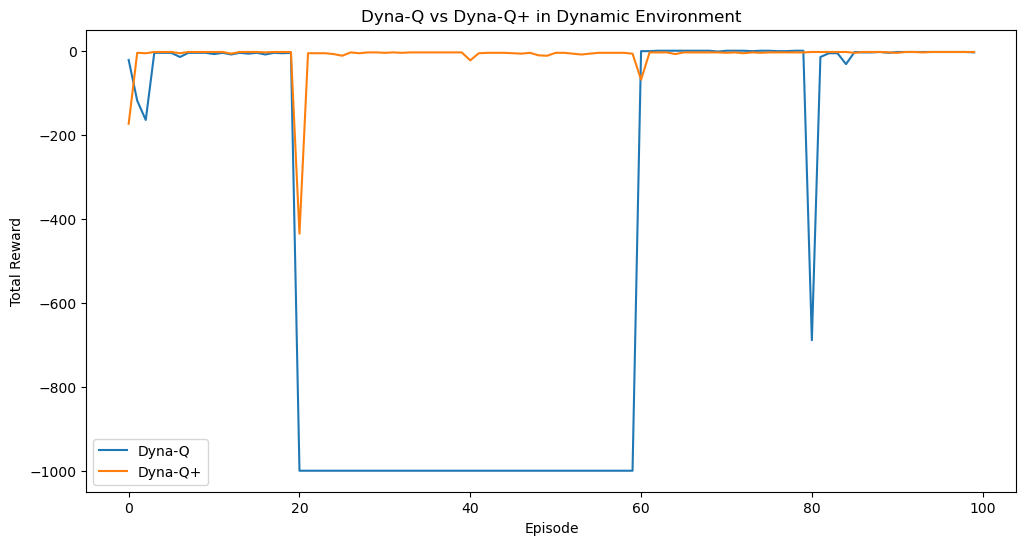

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# 定义动态环境
class DynamicGridWorld:
    def __init__(self, width, height, goal, obstacles):
        self.width = width
        self.height = height
        self.goal = goal  # 初始目标位置
        self.obstacles = obstacles  # 初始障碍物
        self.obstacle_count = len(obstacles)
        self.actions = ['up', 'down', 'left', 'right']
        self.change_interval = 20  # 每 20 个 episode 环境变化一次

    def reset(self):
        # 固定初始位置为 (0, 0)
        self.agent_pos = (0, 0)
        return self.agent_pos

    def step(self, action):
        x, y = self.agent_pos
        if action == 'up':
            y = max(y - 1, 0)
        elif action == 'down':
            y = min(y + 1, self.height - 1)
        elif action == 'left':
            x = max(x - 1, 0)
        elif action == 'right':
            x = min(x + 1, self.width - 1)

        # 检查新位置是否是障碍物
        if (x, y) in self.obstacles:
            x, y = self.agent_pos  # 保持原位置

        self.agent_pos = (x, y)

        # 到达目标则奖励为 1，否则为 -1
        reward = 1 if (x, y) == self.goal else -1
        done = (x, y) == self.goal

        return (x, y), reward, done

    def change_environment(self, episode):
        # 每 20 个 episode 改变目标位置和障碍物
        if episode % self.change_interval == 0 and episode != 0:
            while True:
                # 生成新的目标位置
                new_goal = (random.randint(0, self.width - 1), random.randint(0, self.height - 1))
                # 生成新的障碍物位置（确保不与目标位置重叠）
                new_obstacles = []
                for _ in range(self.obstacle_count):
                    while True:
                        obstacle = (random.randint(0, self.width - 1), random.randint(0, self.height - 1))
                        if obstacle != new_goal and obstacle not in new_obstacles:
                            new_obstacles.append(obstacle)
                            break
                # 确保初始位置 (0, 0) 不与目标位置或障碍物重叠
                if (0, 0) != new_goal and (0, 0) not in new_obstacles:
                    self.goal = new_goal
                    self.obstacles = new_obstacles
                    print(f"Environment changed at episode {episode}: new goal {self.goal}, new obstacles {self.obstacles}")
                    break


# Dyna-Q 算法
class DynaQ:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1, n_planning=5):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_planning = n_planning

        # 初始化 Q 表
        self.Q = {}
        for x in range(env.width):
            for y in range(env.height):
                for action in env.actions:
                    self.Q[(x, y), action] = 0.0

        # 初始化模型
        self.model = {}

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.env.actions)
        else:
            q_values = [self.Q[state, a] for a in self.env.actions]
            max_q = max(q_values)
            candidates = [a for a in self.env.actions if self.Q[state, a] == max_q]
            return random.choice(candidates)

    def update(self, state, action, reward, next_state):
        max_q_next = max([self.Q[next_state, a] for a in self.env.actions])
        self.Q[state, action] += self.alpha * (reward + self.gamma * max_q_next - self.Q[state, action])

    def learn(self, num_episodes):
        episode_rewards = []
        episode_steps = []

        for episode in range(num_episodes):
            # 环境变化检查
            self.env.change_environment(episode)

            state = self.env.reset()
            done = False
            total_reward = 0
            total_steps = 0

            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update(state, action, reward, next_state)
                self.model[state, action] = (next_state, reward)

                # 规划步骤
                for _ in range(self.n_planning):
                    model_state_action = random.choice(list(self.model.keys()))
                    model_next_state, model_reward = self.model[model_state_action]
                    self.update(model_state_action[0], model_state_action[1], model_reward, model_next_state)

                state = next_state
                total_reward += reward
                total_steps += 1
                # 限制最大步数
                if total_steps >= 1000:
                    break

            episode_rewards.append(total_reward)
            episode_steps.append(total_steps)
            #print(f"Episode {episode + 1}, Total Reward: {total_reward}")

        return episode_rewards


# Dyna-Q+ 算法
class DynaQPlus(DynaQ):
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1, n_planning=5, kappa=0.01):
        super().__init__(env, alpha, gamma, epsilon, n_planning)
        self.kappa = kappa
        self.time_since_last_visit = {}
        self.current_time = 0

    def update(self, state, action, reward, next_state):
        # 计算额外奖励
        bonus_reward = self.kappa * np.sqrt(self.current_time - self.time_since_last_visit.get((state, action), 0))
        reward += bonus_reward

        # Q-learning 更新
        max_q_next = max([self.Q[next_state, a] for a in self.env.actions])
        self.Q[state, action] += self.alpha * (reward + self.gamma * max_q_next - self.Q[state, action])

        self.time_since_last_visit[state, action] = self.current_time
        self.current_time += 1


# 测试 Dyna-Q 和 Dyna-Q+
if __name__ == "__main__":
    env = DynamicGridWorld(width=5, height=5, goal=(3, 3), obstacles=[(1, 1), (2, 2), (3, 1), (4, 2)])

    # 运行 Dyna-Q
    dyna_q = DynaQ(env, n_planning=10)
    dyna_q_rewards = dyna_q.learn(num_episodes=100)

    # 运行 Dyna-Q+
    dyna_q_plus = DynaQPlus(env, n_planning=10, kappa=0.01)
    dyna_q_plus_rewards = dyna_q_plus.learn(num_episodes=100)

    plt.figure(figsize=(12, 6))
    # 绘制对比曲线
    plt.plot(dyna_q_rewards, label="Dyna-Q")
    plt.plot(dyna_q_plus_rewards, label="Dyna-Q+")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Dyna-Q vs Dyna-Q+ in Dynamic Environment")
    plt.legend()
    plt.show()